In [1]:
import torch
from transformers import LongformerForSequenceClassification, LongformerTokenizer, Trainer, TrainingArguments
from datasets import load_dataset
import pandas as pd
import os

# 检查设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

c:\Users\DreamDreamer\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [2]:
from datasets import load_dataset, ClassLabel

# 从 CSV 加载数据
data_files = {"data": "../datasets/datasets.csv"}
dataset = load_dataset("csv", data_files=data_files)

# 将标签中的 . 替换为 _
def replace_dot_with_underscore(example):
    return {"label": example["label"].replace(".", "_")}
dataset = dataset.map(replace_dot_with_underscore)

# 获取唯一的标签值
unique_labels = sorted(set(dataset["data"]["label"]))
print("唯一的标签值:", unique_labels)

# 将 label 列转换为 ClassLabel 类型
dataset = dataset.cast_column("label", ClassLabel(names=unique_labels))

# 打印数据集信息
print(dataset)

唯一的标签值: ['cs_AI', 'cs_CE', 'cs_DS', 'cs_IT', 'cs_NE', 'cs_PL', 'cs_SY', 'cs_cv', 'math_AC', 'math_GR', 'math_ST']
DatasetDict({
    data: Dataset({
        features: ['review_id', 'label', 'keywords', 'keysentences', 'abstract'],
        num_rows: 550
    })
})


In [3]:
# 将keywords、keysentences和abstract拼接成text
def concatenate_text(example):
    text = ' '.join([str(example['keywords']), str(example['keysentences']), str(example['abstract'])])
    return {'text': text}
dataset = dataset.map(concatenate_text)

# 划分训练集和验证集，80%训练，20%验证
dataset = dataset['data'].train_test_split(test_size=0.2, stratify_by_column='label', seed=42)
train_dataset = dataset['train']
eval_dataset = dataset['test']

In [4]:
# 获取分类个数
num_classes = len(train_dataset.features['label'].names)
print(f"Number of classes: {num_classes}")
# 加载预训练的Longformer模型和tokenizer
model_name = 'allenai/longformer-base-4096'
tokenizer = LongformerTokenizer.from_pretrained(model_name)
model = LongformerForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)
model.to(device)

Number of classes: 11


Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LongformerForSequenceClassification(
  (longformer): LongformerModel(
    (embeddings): LongformerEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(4098, 768, padding_idx=1)
    )
    (encoder): LongformerEncoder(
      (layer): ModuleList(
        (0-11): 12 x LongformerLayer(
          (attention): LongformerAttention(
            (self): LongformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (query_global): Linear(in_features=768, out_features=768, bias=True)
              (key_global): Linear(in_features=768, out_features=768, bias=True)
          

In [5]:
#数据预处理
def encode_batch(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=1024)

encoded_train_dataset = train_dataset.map(encode_batch, batched=True, batch_size=32)
encoded_eval_dataset = eval_dataset.map(encode_batch, batched=True, batch_size=32)

In [6]:

#设置参数，用Trainer（）创造实例
training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=5e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    warmup_steps=500,
    evaluation_strategy='epoch',
    logging_dir='./logs',
)

# 创建Trainer实例
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_train_dataset,
    eval_dataset=encoded_eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=lambda p: {"accuracy": (p.predictions.argmax(-1) == p.label_ids).mean()},
)

c:\Users\DreamDreamer\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\DreamDreamer\AppData\Local\Temp\ipykernel_27960\3960417624.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [9]:
#模型训练
trainer.train()

  0%|          | 3/660 [00:08<31:47,  2.90s/it]

KeyboardInterrupt: 

In [14]:
# 评估模型
results = trainer.evaluate()
print(results)

100%|██████████| 55/55 [00:12<00:00,  4.35it/s]

{'eval_loss': 1.0366671085357666, 'eval_accuracy': 0.6545454545454545, 'eval_runtime': 13.0081, 'eval_samples_per_second': 8.456, 'eval_steps_per_second': 4.228, 'epoch': 3.0}


In [15]:
# 保存微调后的Longformer模型
model.save_pretrained('./fine-tuned-longformer')
tokenizer.save_pretrained('./fine-tuned-longformer')

('./fine-tuned-longformer\\tokenizer_config.json',
 './fine-tuned-longformer\\special_tokens_map.json',
 './fine-tuned-longformer\\vocab.json',
 './fine-tuned-longformer\\merges.txt',
 './fine-tuned-longformer\\added_tokens.json')

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score

# 定义 compute_metrics 函数
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    acc = accuracy_score(labels, preds)
    macro_f1 = f1_score(labels, preds, average='macro')
    return {"accuracy": acc, "macro_f1": macro_f1}

100%|██████████| 55/55 [00:09<00:00,  5.88it/s]


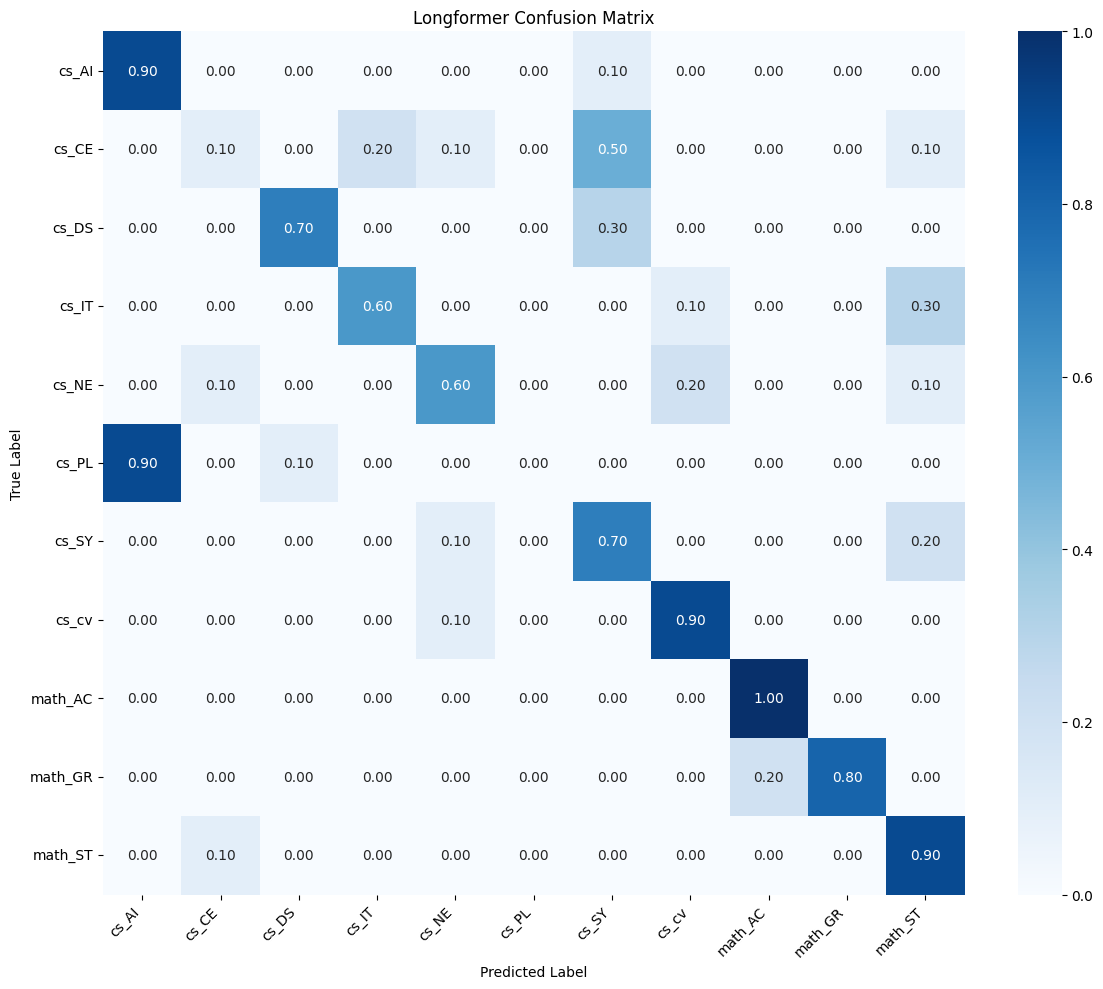

In [28]:
# 获取预测结果
predictions = trainer.predict(encoded_eval_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# 计算混淆矩阵
cm = confusion_matrix(labels, preds)
cm_normalized = confusion_matrix(labels, preds, normalize='true')

# 获取标签名称
label_names = unique_labels

# 绘制混淆矩阵
plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", xticklabels=label_names, yticklabels=label_names, cmap='Oranges')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Longformer Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('./results/(test)Longformer Confusion Matrix.png')
plt.show()

In [29]:
print("\nClassification Report:")
print(classification_report(labels, preds, target_names=label_names))

# 计算并打印 Macro F1
macro_f1 = f1_score(labels, preds, average='macro')
print(f"Macro F1 Score: {macro_f1:.4f}")

report = classification_report(labels, preds, target_names=label_names, output_dict=True)  # 使用 output_dict=True 生成字典
print("\nClassification Report:")
print(report)

# 转换分类报告为 DataFrame
df_report = pd.DataFrame(report).transpose()

# 添加 Macro F1 到分类报告
df_report.loc['macro_f1'] = {'precision': None, 'recall': None, 'f1-score': macro_f1, 'support': None}

# 指定 CSV 文件路径
output_csv_path = './results/(test)Longformer_classification_report.csv'

# 保存为 CSV 文件
df_report.to_csv(output_csv_path, index=True)
print(f"Classification report has been saved to {output_csv_path}")

Macro F1 Score: 0.6109

Classification Report:
{'cs_AI': {'precision': 0.5, 'recall': 0.9, 'f1-score': 0.6428571428571429, 'support': 10.0}, 'cs_CE': {'precision': 0.3333333333333333, 'recall': 0.1, 'f1-score': 0.15384615384615385, 'support': 10.0}, 'cs_DS': {'precision': 0.875, 'recall': 0.7, 'f1-score': 0.7777777777777778, 'support': 10.0}, 'cs_IT': {'precision': 0.75, 'recall': 0.6, 'f1-score': 0.6666666666666666, 'support': 10.0}, 'cs_NE': {'precision': 0.6666666666666666, 'recall': 0.6, 'f1-score': 0.631578947368421, 'support': 10.0}, 'cs_PL': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10.0}, 'cs_SY': {'precision': 0.4375, 'recall': 0.7, 'f1-score': 0.5384615384615384, 'support': 10.0}, 'cs_cv': {'precision': 0.75, 'recall': 0.9, 'f1-score': 0.8181818181818182, 'support': 10.0}, 'math_AC': {'precision': 0.8333333333333334, 'recall': 1.0, 'f1-score': 0.9090909090909091, 'support': 10.0}, 'math_GR': {'precision': 1.0, 'recall': 0.8, 'f1-score': 0.8888888888888888,

c:\Users\DreamDreamer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DreamDreamer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DreamDreamer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  